Evolving t1=2.0, t2=1.0: 100%|██████████| 400000/400000 [2:35:49<00:00, 42.78it/s]  
C:\Users\zimme\AppData\Local\Temp\ipykernel_16372\707930238.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pumped_charge = np.trapz(avg_current, time)  # integral over one period
Evolving t1=1.0, t2=2.0: 100%|██████████| 400000/400000 [1:33:15<00:00, 71.49it/s]  


Pumped charge per cycle (t1=2,t2=1): -4.904172683506403e-07
Pumped charge per cycle (t1=1,t2=2): 1.029913840433494e-06


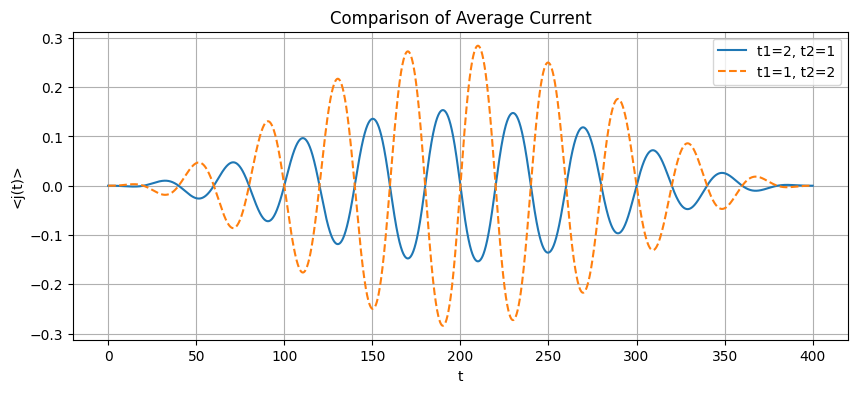

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Put your fixed functions here: A_t(t), H_elements(k, At, t1, t2), current_operator(k, At, t1, t2)
# (Use the unitary evolution approach from the fixed script.)

# Example: reuse the functions but allow t1,t2 as args
def H_elements(k, At, t1, t2):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    Hpp = (t2**2*np.cos(At) + t1**2 + t1*t2*(np.cos(k) + np.cos(k - At))) / denom
    Hmm = -Hpp
    Hpm = 1j * t2 * (t2 * np.sin(At) + t1 * (np.sin(k) - np.sin(k - At))) / denom
    Hmp = np.conj(Hpm)
    return np.array([[Hpp, Hpm],[Hmp, Hmm]], dtype=complex)

def current_operator(k, At, t1, t2):
    denom = np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    dHpp = -t1 * t2 * np.sin(k) / denom
    dHmm = -dHpp
    dHpm = 1j * t1 * t2 * np.cos(k) / denom
    dHmp = np.conj(dHpm)
    return np.array([[dHpp, dHpm],[dHmp, dHmm]], dtype=complex)

def A_t(t, A0=0.5, Nc=10, omega0=np.pi/(2*10)):
    return A0 * np.sin(omega0 * t) * (np.sin(omega0 * t / (2 * Nc)))**2

def run_sim(t1, t2, dt=0.001, Nk=251, A0=0.5, Nc=10):
    omega0 = np.pi/(2*Nc)
    dk = 2 * np.pi / Nk
    k_values = np.linspace(-np.pi, np.pi, Nk, endpoint=False)
    T = 2 * np.pi * Nc / omega0
    Nt = int(np.round(T / dt))
    # initial rho: lower band occupied
    rho0 = np.array([[0,0],[0,1]], dtype=complex)
    rho_k = np.tile(rho0, (Nk,1,1)).astype(complex)

    avg_current = np.zeros(Nt)
    for n in tqdm(range(Nt), desc=f"Evolving t1={t1}, t2={t2}"):
        t = n * dt
        At = A_t(t, A0=A0, Nc=Nc, omega0=omega0)
        j_total = 0.0
        for i, k in enumerate(k_values):
            H = H_elements(k, At, t1, t2)
            evals, evecs = np.linalg.eigh(H)
            U = evecs @ np.diag(np.exp(-1j * evals * dt)) @ evecs.conj().T
            rho_k[i] = U @ rho_k[i] @ U.conj().T
            J = current_operator(k, At, t1, t2)
            j_total += np.trace(J @ rho_k[i]).real * dk / (2*np.pi)
        avg_current[n] = j_total
    time = np.linspace(0, T, Nt)
    pumped_charge = np.trapz(avg_current, time)  # integral over one period
    return time, avg_current, pumped_charge

# Run both cases
time, j1, q1 = run_sim(t1=2.0, t2=1.0)
_,   j2, q2 = run_sim(t1=1.0, t2=2.0)

print("Pumped charge per cycle (t1=2,t2=1):", q1)
print("Pumped charge per cycle (t1=1,t2=2):", q2)

# Plot comparison
plt.figure(figsize=(10,4))
plt.plot(time, j1, label='t1=2, t2=1')
plt.plot(time, j2, label='t1=1, t2=2', linestyle='--')
plt.xlabel('t')
plt.ylabel('<j(t)>')
plt.legend()
plt.title('Comparison of Average Current')
plt.grid(True)
plt.show()
